In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
# from read_fk_table import get_fk_table
from read_faserv_pdf import read_pdf
# from read_LHEF import read_LHEF_data
from data_errors import compute_errors
from MC_data_reps import generate_MC_replicas
from postfit_criteria import Postfit
from form_loss_fct import complete_loss_fct, raw_loss_fct
from postfit_measures import Measures
from logspace_grid import generate_grid
# from rebin_fk_data import rebin_fk

In [2]:
# Define global variables
num_obs = 1 #between 1 and 4
REPLICAS  = 1

#HYPERPARAMETERS
preproc = 1
l1 = 6
l2 = 8
l3 = 6

fit_level = 2

lr = 0.1
max_counter = 50
max_Nepochs = 3500

In [3]:
def read_LHEF_data():
    """Read histograms of data

    Args:
        num_obs (int): number of files to read data from

    Returns:
        tuple: returns tuple of lists and arrays containing the data
    """

    filenames = ["data_Enu_mub"]
    (binwidths, events, xvals_per_obs, max_events, min_events, xlabels) = (
        [],
        [],
        [],
        [],
        [],
        [],
    )
    val= np.loadtxt(f"data/{filenames[0]}.dat", unpack=True)

    
    diff = 100
    # val *= diff 
    err = val/20
    events = val
    xvals_per_obs = np.arange(0, 6000, 100)
    min_events = val - err
    max_events = (val + err)
    binwidths = diff 

    xlabels.append(filenames[0].replace(".dat", ""))

    events_per_obs = events

    return (
        events,
        max_events,
        min_events,
        xvals_per_obs,
        binwidths,
        xlabels,
        events_per_obs,
    )

In [4]:
# from read_fk_table import get_fk_table

import pandas as pd
# import torch
import torch.nn.functional


def get_fk_table(filename):
    """This function reads the fk table for the neutrino flux and pads them for computational efficiency later on

    Returns:
        tuple: x_alphas(grid points) and the fk table in tensor to fit torch
    """

    file_path_n = f"data/{filename}_n.dat"
    df_n = pd.read_csv(file_path_n, sep="\s+", header=None)
    fk_table_n = df_n.to_numpy()

    file_path_p = f"data/{filename}_p.dat"
    df_p = pd.read_csv(file_path_p, sep="\s+", header=None)
    fk_table_p = df_p.to_numpy()

    x_alpha = fk_table_p[0, :]
    x_alpha = x_alpha.reshape(len(x_alpha), 1)

    fk_table = (74 / 183 )* fk_table_p + ((183 - 74) / 183) * fk_table_n

    # strip first row to get fk table
    fk_table = fk_table[1:, :]

    x_alpha = torch.tensor(x_alpha, dtype=torch.float32).view(-1, 1)
    fk_table = torch.tensor(fk_table, dtype=torch.float32)

    return x_alpha, fk_table

filename = "FK_Enu_mub"
x_alphas, fk_tables_mu = get_fk_table(filename = filename)

<>:16: SyntaxWarning: invalid escape sequence '\s'
<>:20: SyntaxWarning: invalid escape sequence '\s'
<>:16: SyntaxWarning: invalid escape sequence '\s'
<>:20: SyntaxWarning: invalid escape sequence '\s'
/var/folders/ph/sg5840xd0fxgcl0kh643h5_00000gp/T/ipykernel_60430/215647774.py:16: SyntaxWarning: invalid escape sequence '\s'
  df_n = pd.read_csv(file_path_n, sep="\s+", header=None)
/var/folders/ph/sg5840xd0fxgcl0kh643h5_00000gp/T/ipykernel_60430/215647774.py:20: SyntaxWarning: invalid escape sequence '\s'
  df_p = pd.read_csv(file_path_p, sep="\s+", header=None)


In [5]:
pdf = 'faserv'
faser_pdf,x_faser = read_pdf(pdf,x_alphas.flatten(),-14)
faser_pdf = torch.tensor(faser_pdf, dtype=torch.float32).view(-1,1)
conv = torch.matmul(fk_tables_mu,faser_pdf) * 100 
print(conv.detach().flatten())

LHAPDF 6.5.4 loading /opt/anaconda3/envs/ML_fit/share/LHAPDF/faserv/faserv_0000.dat
faserv PDF set, member #0, version 1; LHAPDF ID = 50000001
tensor([0.0000e+00, 1.5055e-03, 1.0321e+01, 3.1921e+01, 5.0069e+01, 5.9244e+01,
        6.2151e+01, 5.9295e+01, 5.4857e+01, 4.9622e+01, 4.3968e+01, 3.9708e+01,
        3.6481e+01, 3.3629e+01, 3.0472e+01, 2.7220e+01, 2.4746e+01, 2.2202e+01,
        2.0258e+01, 1.8623e+01, 1.6941e+01, 1.5235e+01, 1.3816e+01, 1.2028e+01,
        1.1045e+01, 9.5024e+00, 8.6930e+00, 7.7280e+00, 6.5574e+00, 6.0087e+00,
        5.3645e+00, 4.7252e+00, 4.3180e+00, 3.8291e+00, 3.2438e+00, 2.9043e+00,
        2.7127e+00, 2.3405e+00, 2.0460e+00, 1.8672e+00, 1.7539e+00, 1.5232e+00,
        1.3329e+00, 1.2057e+00, 1.1205e+00, 9.6211e-01, 7.8746e-01, 7.1257e-01,
        6.4300e-01, 5.7126e-01, 4.7518e-01, 4.0215e-01, 3.5412e-01, 3.1831e-01,
        2.7942e-01, 2.2005e-01, 1.6886e-01, 1.3622e-01, 1.2906e-01, 1.1680e-01])


/var/folders/ph/sg5840xd0fxgcl0kh643h5_00000gp/T/ipykernel_60430/549442755.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  faser_pdf = torch.tensor(faser_pdf, dtype=torch.float32).view(-1,1)


In [6]:
events, max_events, min_events, xvals_per_obs, binwidths, xlabels, events_per_obs, = read_LHEF_data()

def rebin_fk(faser_bins,fk_tables,data,data_max,data_min):

    xvals_per_obs = np.arange(0, 6000, 100)
    print(xvals_per_obs)
    # data = np.array(data)
    data_faser,data_faser_min,data_faser_max, = [],[],[]
    fk_tables_faser = []
    lower_bound = 100
    # faser_bins = [300, 600, 1000,1900]
    for bin_val in faser_bins:
        indices = np.where((xvals_per_obs < bin_val) & (xvals_per_obs >= lower_bound))[0]

        print(indices)

        data_faser.append(np.sum(data[min(indices):max(indices)+1]))
        data_faser_min.append(np.sum(data_min[min(indices):max(indices)+1]))
        data_faser_max.append(np.sum(data_max[min(indices):max(indices)+1]))

        # xvals_per_obs = xvals_per_obs[max(indices)  :]
  
        summed_column = torch.sum(fk_tables[min(indices):max(indices) +1, :], axis=0)
        summed_column = summed_column.unsqueeze(0)

        fk_tables_faser.append(summed_column)

        # min_range = max_range
        lower_bound = bin_val

    # xvals_per_obs_faser.append(xvals_per_obs[-1])    
    # summed_column = torch.sum(fk_tables[max_range:, :], axis=0)
    # summed_column = summed_column.unsqueeze(0)
    # data_faser.append(np.sum(data[max_range:]))
    # data_faser_min.append(np.sum(data_min[max_range:]))
    # data_faser_max.append(np.sum(data_max[max_range:]))
    # fk_tables_faser.append(summed_column)


    fk_tables_faser = torch.cat(fk_tables_faser, dim=0)

    
    data_faser = np.array(data_faser)
    data_faser_min = np.array(data_faser_min)
    data_faser_max = np.array(data_faser_max)


    return data_faser, data_faser_min, data_faser_max, xvals_per_obs, binwidths, xlabels, events_per_obs,fk_tables_faser

# faser_bins_mu = [1220,2713.75, 4207.5,6000]
faser_bins_mu = [300, 600,1000,1900]
data, data_min, data_max, xvals_per_obs, binwidths, xlabels, events_per_obs,fk_table_mu = rebin_fk(faser_bins_mu,fk_tables_mu,events,max_events,min_events)

xvals_per_obs_mu = [300, 600,1000,1900]
xvals_per_obs = [300, 600,1000,1900]


[   0  100  200  300  400  500  600  700  800  900 1000 1100 1200 1300
 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700
 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100
 4200 4300 4400 4500 4600 4700 4800 4900 5000 5100 5200 5300 5400 5500
 5600 5700 5800 5900]
[1 2]
[3 4 5]
[6 7 8 9]
[10 11 12 13 14 15 16 17 18]


LHAPDF 6.5.4 loading /opt/anaconda3/envs/ML_fit/share/LHAPDF/faserv/faserv_0000.dat
faserv PDF set, member #0, version 1; LHAPDF ID = 50000001
LHAPDF 6.5.4 loading /opt/anaconda3/envs/ML_fit/share/LHAPDF/faserv/faserv_0000.dat
faserv PDF set, member #0, version 1; LHAPDF ID = 50000001


/var/folders/ph/sg5840xd0fxgcl0kh643h5_00000gp/T/ipykernel_60430/3388623743.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  faser_pdf = torch.tensor(faser_pdf, dtype=torch.float32).view(-1,1)
/var/folders/ph/sg5840xd0fxgcl0kh643h5_00000gp/T/ipykernel_60430/3388623743.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  faser_pdf = torch.tensor(faser_pdf, dtype=torch.float32).view(-1,1)


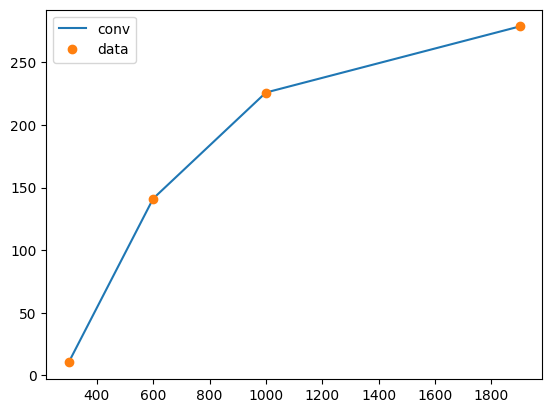

In [7]:
pdf = "faserv"
faser_pdf,x_faser = read_pdf(pdf,x_alphas.flatten(),-14)
faser_pdf = torch.tensor(faser_pdf, dtype=torch.float32).view(-1,1)
conv = torch.matmul(fk_table_mu,faser_pdf) * binwidths 
plt.plot(xvals_per_obs_mu,conv,label='conv')

faser_pdf,x_faser = read_pdf(pdf,x_alphas.flatten(),-14)
faser_pdf = torch.tensor(faser_pdf, dtype=torch.float32).view(-1,1)
plt.plot(xvals_per_obs,data,'o',label='data')
plt.legend()



In [8]:
#Get errors
sig_sys,sig_tot, cov_matrix = compute_errors(data,data_min,data_max)  
sig_stat = np.sqrt(data)
# xvals_per_obs = [100,300,600,-100,-300,1000] 
# xvals_per_obs = [100,300,600,100,-300,-100]  
# cov_matrix = np.array([
#     [9.2,-0.32,  0.08, -0.03,  0.00,  0.00],
#     [-0.32, 10.2, -0.43,  0.10, -0.01, -0.00],
#     [ 0.08, -0.43, 9.6, -0.31,  0.04, -0.02],
#     [-0.03,  0.10, -0.31, 22.3,-0.14,  0.01],
#     [ 0.00, -0.01,  0.04, -0.14, 12.1,-0.24],
#     [ 0.00, -0.00, -0.02,  0.01, -0.24,7.5]
# ])
# sig_sys = np.array(sig_sys)
# np.fill_diagonal(cov_matrix, sig_stat**2 + sig_sys**2)
# cov_matrix = np.linalg.inv(cov_matrix)
# cov_matrix = torch.tensor(cov_matrix, dtype=torch.float32, requires_grad=False)
#Generate MC replicas of data
level0,level1,level2 = generate_MC_replicas(REPLICAS,data,sig_sys,sig_stat)
# Get faserv pdf
pdf = "faserv"
lowx = -8
n=250
x_vals = generate_grid(lowx,n)
faser_pdf,x_faser = read_pdf(pdf,x_vals,14)

delta plus = [ 0.51612528  7.0617     11.29625    13.9342    ]
sig sys = [ 0.51612528  7.0617     11.29625    13.9342    ]
[ 0.51612528  7.0617     11.29625    13.9342    ]
[ 3.21286562 11.88419118 15.03080171 16.6938312 ]
1
[ -0.04088082  -2.83389883 -19.79836839  -9.96028739] [  3.72039212 -11.49729514  -7.68477481  -9.0877542 ]
2
[-0.26475215  9.56134323 -4.57368388 12.67994483] [-2.57535762 -9.93486454  3.38179468 -2.09089686]
LHAPDF 6.5.4 loading /opt/anaconda3/envs/ML_fit/share/LHAPDF/faserv/faserv_0000.dat
faserv PDF set, member #0, version 1; LHAPDF ID = 50000001


In [9]:
if fit_level ==0:
    pred = level0
if fit_level ==1:
    pred = level1
if fit_level ==2:
    pred = level2

[ 10.3225055 141.234     225.925     278.684    ]
[tensor([ 14.0020, 126.9028, 198.4419, 259.6360])]
[tensor([ 11.1619, 126.5293, 197.2500, 270.2250])]


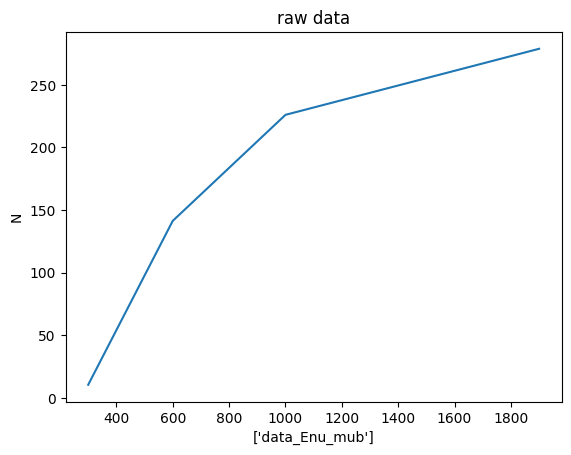

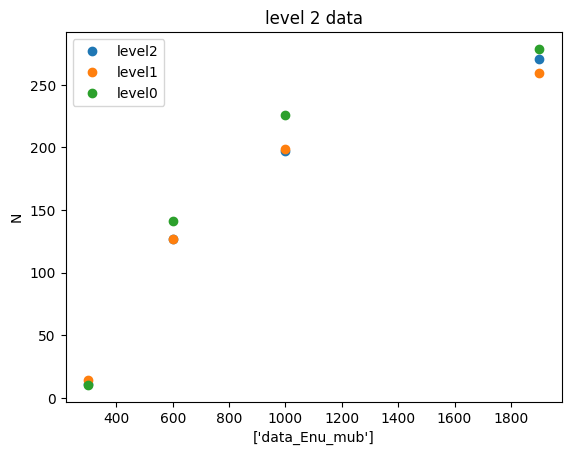

In [10]:
print(data)
print(level1)
print(level2)
plt.plot(xvals_per_obs,data)
plt.xlabel(xlabels)
plt.ylabel('N')
plt.title("raw data")
plt.show()

for i in range(REPLICAS):
    plt.plot(
        xvals_per_obs, level2[i], 'o',label="level2"
    )
    plt.plot(
        xvals_per_obs, level1[i], 'o',label="level1"
    )
    plt.plot(xvals_per_obs, data,'o',label="level0")
    plt.xlabel(xlabels)
    plt.legend()
    plt.ylabel("N")
    plt.title("level 2 data")
    plt.show()


In [11]:
class SimplePerceptron(torch.nn.Module):
    def __init__(self, l1,l2,l3):
        super(SimplePerceptron, self).__init__()
        self.linear = torch.nn.Linear(1,l1)
        self.hidden = torch.nn.Linear(l1,l2)
        self.hidden2 = torch.nn.Linear(l2,l3)
        self.hidden3 = torch.nn.Linear(l3,1)
        self.relu = torch.nn.ReLU()

    def forward(self, y):
        y = self.linear(y)
        y = self.relu(y)
        y = self.hidden(y)
        y = self.relu(y)
        y = self.hidden2(y)
        y = self.relu(y)
        y = self.hidden3(y)
        y = self.relu(y)
        # y = torch.nn.functional.softplus(y)
    
        return y

In [12]:
import torch.nn as nn

if preproc == 1:
    class CustomPreprocessing(nn.Module):
        def __init__(self, alpha,beta,gamma):
            super(CustomPreprocessing, self).__init__()

            self.alpha = nn.Parameter(torch.tensor(alpha, dtype=torch.float32, requires_grad=True))
            self.beta = nn.Parameter(torch.tensor(beta, dtype=torch.float32, requires_grad=True))
            self.gamma = nn.Parameter(torch.tensor(gamma, dtype=torch.float32, requires_grad=True))

            # self.register_buffer("alpha", torch.tensor(alpha, dtype=torch.float32))
            # self.register_buffer("beta", torch.tensor(beta, dtype=torch.float32))
            # self.register_buffer("gamma", torch.tensor(gamma, dtype=torch.float32))

        def forward(self, x):
            # alpha = (1 - 0.2)/2 *torch.tanh(self.alpha) + (1 + 0.2)/2
            # beta = (1.9 - 0.1)/2 *torch.tanh(self.alpha) + (1.9 + 0.1)/2
            # beta = abs(self.beta)
            alpha = 1 - torch.nn.functional.softplus(self.alpha)
            return self.gamma * (1 - x) ** self.beta * x**(1-alpha) 
            # return 10 * (1 - x)**2 * x**(1.5) 
            # return  self.gamma*(1 - x) ** self.beta * x**(1-self.alpha) 
        
    class PreprocessedMLP(nn.Module):
        def __init__(self, alpha, beta, gamma,l1, l2, l3):
            super(PreprocessedMLP, self).__init__()
            self.preprocessing = CustomPreprocessing(alpha, beta,gamma)
            self.mlp = SimplePerceptron(l1, l2, l3)

        def forward(self, x):
            f_preproc = self.preprocessing(x)
            f_NN = self.mlp(x)
            f_nu = f_preproc * f_NN
            return f_nu
        
        def neuralnet(self, x):
            f_NN = self.mlp(x)
            return f_NN
        
        def preproc(self, x):
            f_preproc = self.preprocessing(x)
            return f_preproc
        


In [13]:
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss,self).__init__()

    def forward(self,pred,
    data,
    cov_matrix):
        loss = raw_loss_fct(pred,
    data,
    cov_matrix)
        return loss

In [14]:
#Define variables for fit
# x_alpha_more_bins = np.logspace(-5,0,250)
# x_alpha_more_bins = torch.tensor(x_alpha_more_bins, dtype=torch.float32).view(-1,1)
lowx = -8
n=250
x_vals = generate_grid(lowx,n)
x_vals = torch.tensor(x_vals, dtype=torch.float32).view(-1,1)
neutrino_pdfs_mu,neutrino_pdfs_mub,N_event_pred, arc_lenghts, chi_squares, int_penaltys,pos_penaltys, preproc_pdfs, nn_pdfs  = [],[],[],[],[],[],[],[],[]

In [15]:
if preproc == 1:
    alpha,beta,gamma = 1,1,10
    model = PreprocessedMLP(alpha, beta, gamma,l1, l2, l3)
         
            # model.load_state_dict(model_params)    

    criterion = CustomLoss()
        # criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
def perform_fit(pred,REPLICAS):
    for i in range(REPLICAS):
        losses = []
        
        pred[i] = pred[i].squeeze()
        model.train()
        best_loss = 1e13 # initial loss
        counter = 0
        num_epochs = 6000
        for ep in range(num_epochs):
        # while counter < max_counter:  
        #     if num_epochs>max_Nepochs:
        #         break
            
            # num_epochs+=1
            optimizer.zero_grad()
            # y_pred =  model(x_alphas) 
            y_pred =  model(x_alphas) * x_alphas
            y_preds = torch.matmul(fk_table_mu,y_pred)  * binwidths 

            y_preds = y_preds.squeeze()

            loss = criterion(y_preds, pred[i],cov_matrix)
            loss.backward()
            # print(loss)
    
            losses.append(loss.item())
            optimizer.step()
            
            if ep % 100 == 0:
                print(loss.detach().numpy())   
            if loss <.002:
                break
            # if loss < best_loss:
            #     best_loss = loss
            #     counter = 0
            # else:
            #     counter +=1   

        if loss < 10:    

            print(f"reduced chi^2 level 2 = {loss}")
            # print(f"reduced chi^2 level 1 = {red_chi_square_level1}")
            print(f"Constrained alpha: {(model.preprocessing.alpha.item())}")
            print(f"Constrained beta: {(model.preprocessing.beta.item())}")
            print(f"Constrained gamma: {model.preprocessing.gamma.item()}") 

            # save outcome of fit and its measures for postfit selection criteria
            chi_squares.append(loss.detach().numpy())
            # preproc_pdf = ((1 - x_alpha_more_bins) ** (beta) * x_alpha_more_bins ** (1-alpha)).detach().numpy().flatten()
            f_nu_mu = model(x_vals).detach().numpy().flatten() 
            
            # print(preproc_pdf.shape)

            preproc_pdfs.append(model.preproc(x_vals).detach().numpy().flatten())
            nn_pdfs.append(model.neuralnet(x_vals).detach().numpy().flatten())

            N_event_pred.append(y_preds.detach().numpy())
            # cont_pred = model(x_alpha_more_bins).detach().numpy().flatten()
            neutrino_pdfs_mu.append(f_nu_mu)
            plt.yscale('log')
            print(f'counter = {counter}')
            plt.plot(range(1, len(losses) + 1), losses)
            plt.xlabel('#epochs')
            plt.ylabel('loss')
            plt.title('level 0 closure test, no preprocessing')
            plt.show()
            # plt.plot(x_alpha_more_bins,preproc_pdf)
            # plt.xscale('log')
            # plt.yscale('log')
            # plt.show()
    # return arc_lenghts, chi_squares,pos_penaltys,int_penaltys,N_event_pred, neutrino_pdfs,model
    return chi_squares,N_event_pred, neutrino_pdfs_mu,neutrino_pdfs_mub,model

90.00644
43.105545
40.246517
33.972477
7.664342
1.4843326
1.1693349
1.1645827
1.1593336
1.1535852
1.1473304
1.1407925
1.1332142
1.1255759
1.1169411
1.1079981
1.0984674
1.0882776
1.0775189
1.0661135
1.0541348
1.0412387
1.0277692
1.0135655
0.99863875
0.9828828
0.96639717
0.9491297
0.93108195
0.9122651
0.89269817
0.82004744
0.5930119
0.49297014
0.41852573
0.33681622
0.24613653
0.16110408
0.0820688
0.03639429
0.011624512
0.003234315
reduced chi^2 level 2 = 0.0018537434516474605
Constrained alpha: -6.782976150512695
Constrained beta: 32.736183166503906
Constrained gamma: 36.66007614135742
counter = 0


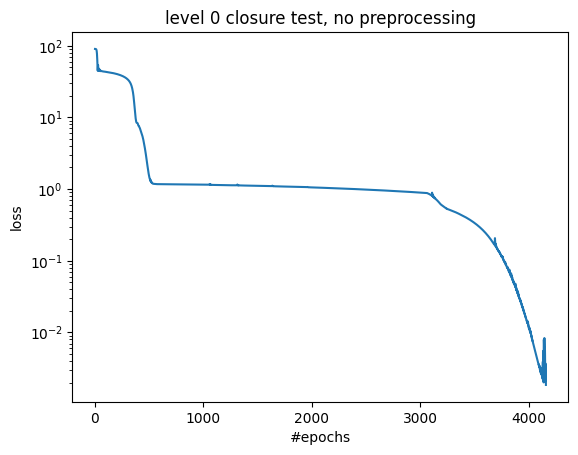

In [16]:
chi_squares,N_event_pred, neutrino_pdfs_mu,neutrino_pdfs_mub,model = perform_fit(pred,REPLICAS)

In [17]:
closure_fit = Postfit()
# neutrino_pdfs, N_event_pred = closure_fit.apply_postfit_criteria(chi_squares,N_event_pred,neutrino_pdfs)

In [18]:
x_vals = x_vals.detach().numpy().flatten()
faser_pdf_mu,x_faser = read_pdf(pdf,x_vals,14) 
# mean_fnu = np.mean(neutrino_pdfs,axis=0) *x_vals
mean_fnu_mu = np.mean(neutrino_pdfs_mu,axis=0) 
mean_fnu_mub = np.mean(neutrino_pdfs_mub,axis=0) 

mean_pdf_preproc = np.mean(preproc_pdfs,axis=0) 
mean_nn_pdf = np.mean(nn_pdfs,axis=0) 

LHAPDF 6.5.4 loading /opt/anaconda3/envs/ML_fit/share/LHAPDF/faserv/faserv_0000.dat
faserv PDF set, member #0, version 1; LHAPDF ID = 50000001


/opt/anaconda3/envs/ML_fit/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/ML_fit/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [19]:
# from lhapdf_grid import write_lhapdf_grid
# mean_fnu = np.mean(neutrino_pdfs, axis=0) * x_vals
# lhapdfpath = '/opt/anaconda3/envs/nnpdf_dev/share/LHAPDF/enu/enu_0000.dat'

# write_lhapdf_grid(x_vals,mean_fnu,lhapdfpath)

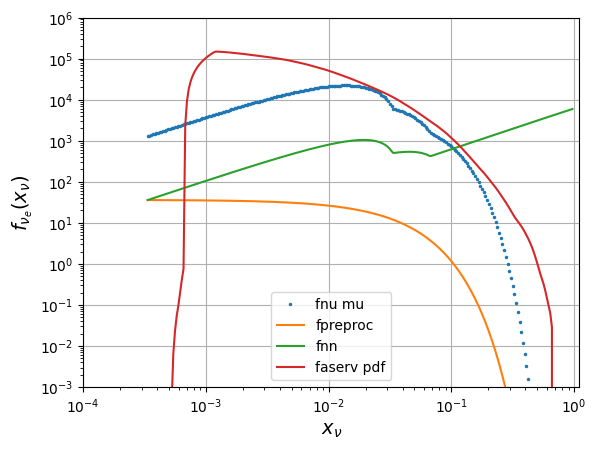

In [20]:
# plt.plot(cont_x,mean_pdf_preproc*mean_nn_pdf*(x_alpha_more_bins.detach().numpy().flatten()),label = 'mult' )
plt.plot(x_vals,mean_fnu_mu*x_vals,'o',label="fnu mu",markersize=1.5)
plt.plot(x_vals,mean_pdf_preproc,label="fpreproc",markersize=1.5)
plt.plot(x_vals,mean_nn_pdf*x_vals,label="fnn",markersize=1.5)
# plt.axvline(x=min(xvals_per_obs[0])/14000, color='green', linestyle='--', label='no data to the left of this line')
plt.plot(x_faser,faser_pdf_mu,label ='faserv pdf')
plt.xlabel(r"$x_{\nu}$",fontsize = 14)
plt.ylabel(r"$f_{\nu_e}(x_{\nu})$",fontsize = 14)
plt.ylim(10**-3,10**6)
plt.xlim(10**-4,1.1)
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.legend()
plt.show()

LHAPDF 6.5.4 loading /opt/anaconda3/envs/ML_fit/share/LHAPDF/faserv/faserv_0000.dat
faserv PDF set, member #0, version 1; LHAPDF ID = 50000001


/Users/jukkajohn/Masterscriptie/faser_nufluxes_ml/ML_fit_enu/src/ML_fit_neutrinos/plot_results.py:71: RuntimeWarning: divide by zero encountered in divide
  ratio_center = mean_fnu / faser_pdf
/Users/jukkajohn/Masterscriptie/faser_nufluxes_ml/ML_fit_enu/src/ML_fit_neutrinos/plot_results.py:71: RuntimeWarning: invalid value encountered in divide
  ratio_center = mean_fnu / faser_pdf
/Users/jukkajohn/Masterscriptie/faser_nufluxes_ml/ML_fit_enu/src/ML_fit_neutrinos/plot_results.py:72: RuntimeWarning: divide by zero encountered in divide
  ratio_lower = (mean_fnu - error_fnu) / faser_pdf
/Users/jukkajohn/Masterscriptie/faser_nufluxes_ml/ML_fit_enu/src/ML_fit_neutrinos/plot_results.py:72: RuntimeWarning: invalid value encountered in divide
  ratio_lower = (mean_fnu - error_fnu) / faser_pdf
/Users/jukkajohn/Masterscriptie/faser_nufluxes_ml/ML_fit_enu/src/ML_fit_neutrinos/plot_results.py:73: RuntimeWarning: divide by zero encountered in divide
  ratio_upper = (mean_fnu + error_fnu) / faser_pd

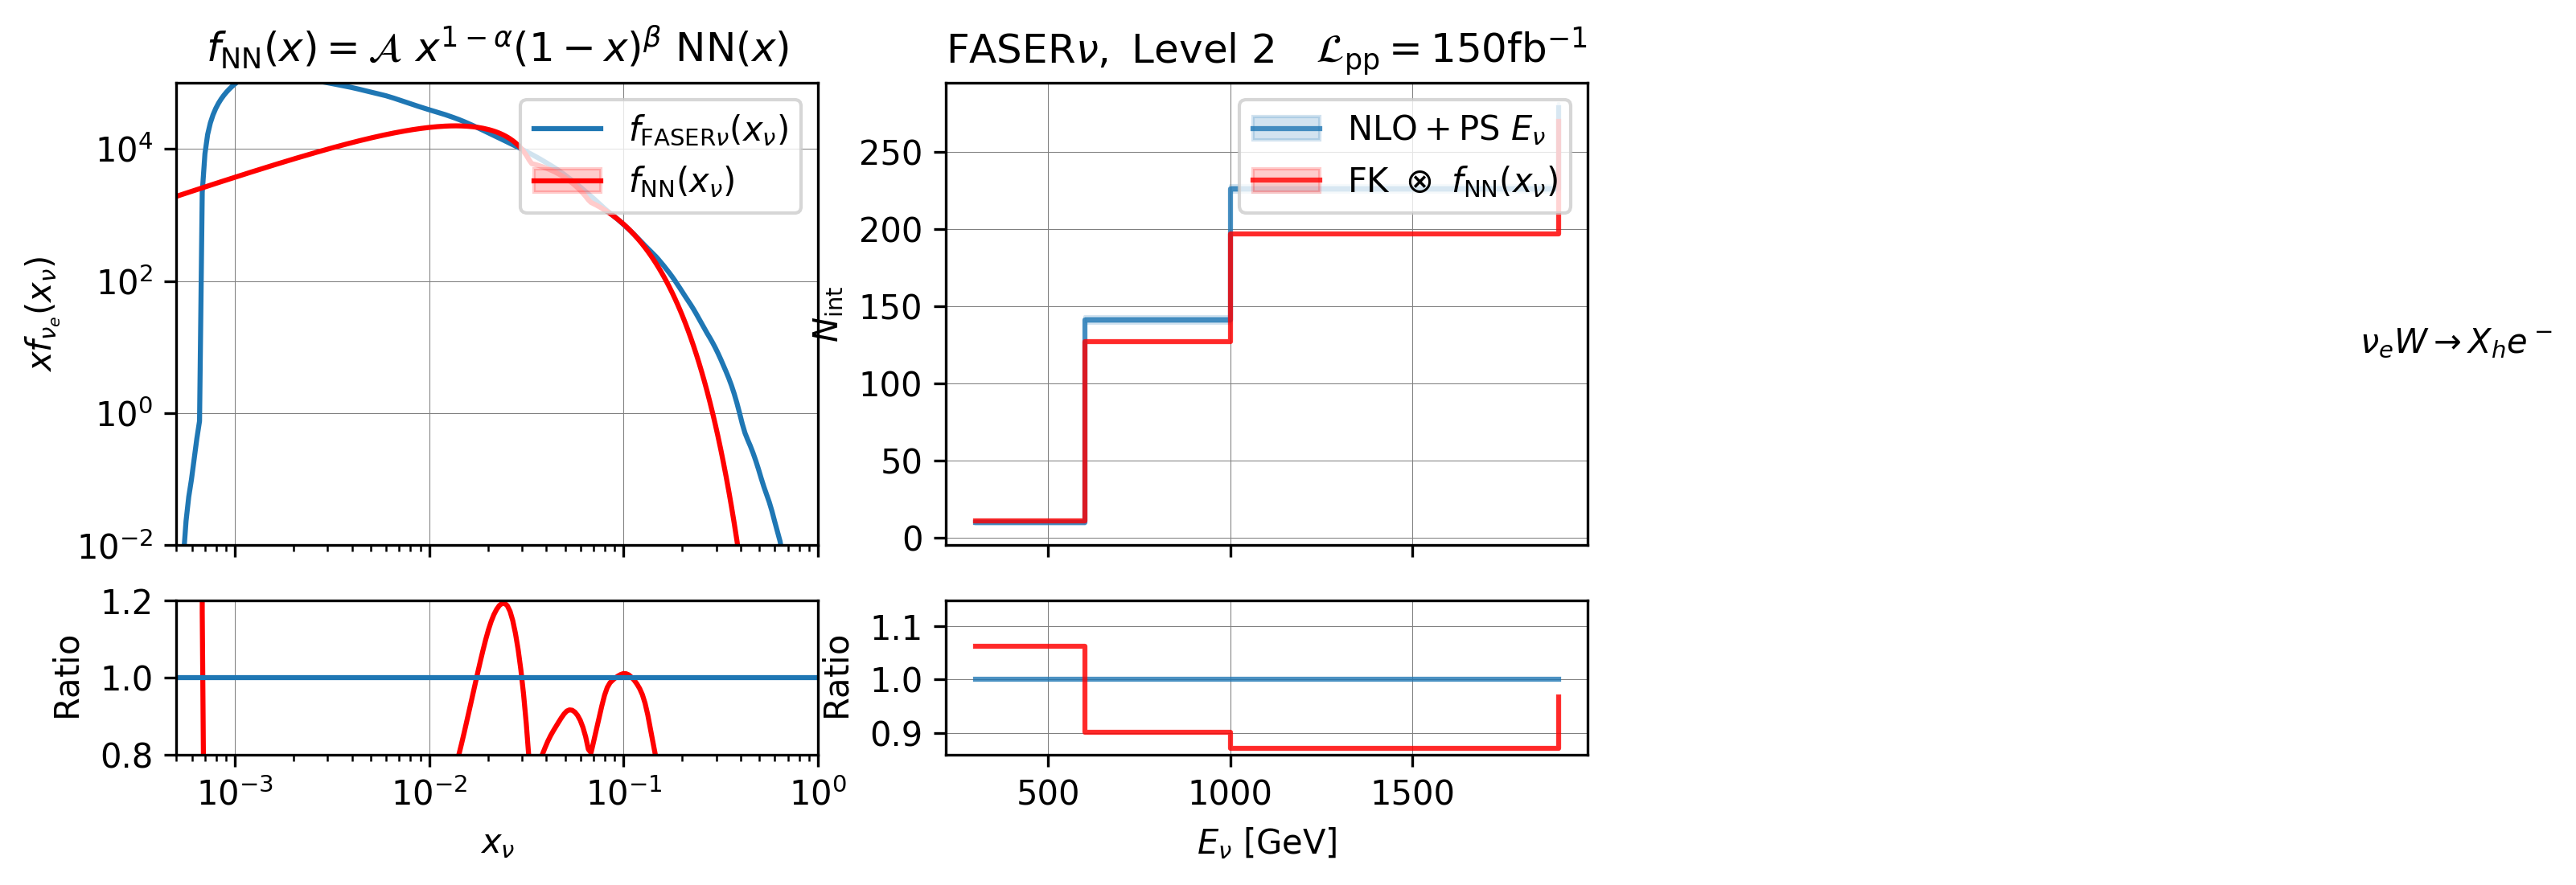

In [21]:
from plot_results import plot
import numpy as np
sig_tot = np.sqrt(sig_sys+sig_stat)
x_vals = np.array(x_vals)
plot(x_vals, neutrino_pdfs_mu, level0, N_event_pred, sig_tot, xvals_per_obs,-14)


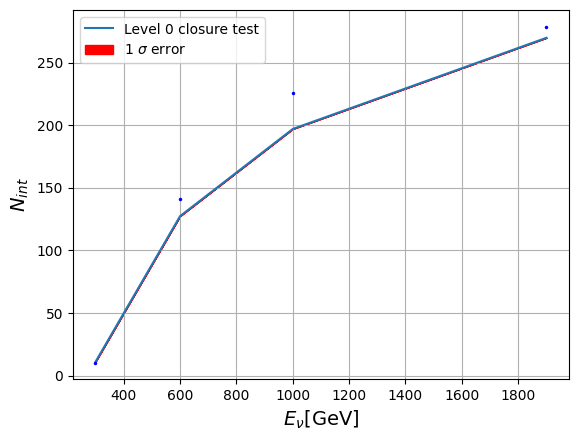

In [22]:

mean_N_event_fits = np.mean(N_event_pred,axis=0)
sigma_N_event_fits = np.std(N_event_pred,axis=0)

mean_N_event_fit = mean_N_event_fits.flatten()
sigma_N_event_fit = sigma_N_event_fits.flatten()
xvals_per_obs = np.array(xvals_per_obs)
sorted_indices = np.argsort(xvals_per_obs)

# Sort both arrays using the same indices
sorted_xvals_per_obs = xvals_per_obs[sorted_indices]
sorted_mean_N_event_fit = mean_N_event_fit[sorted_indices]
sorted_sigma_N_event_fit = sigma_N_event_fit[sorted_indices]
level0data = level0[0]
sorted_level0 = level0data[sorted_indices]

plt.plot(sorted_xvals_per_obs,sorted_mean_N_event_fit,label="Level 0 closure test")

plt.fill_between(sorted_xvals_per_obs,(sorted_mean_N_event_fit+sorted_sigma_N_event_fit),(sorted_mean_N_event_fit-sorted_sigma_N_event_fit),label=r"1 $\sigma$ error",color = 'red')

# plt.plot(xvals_per_obs[i],events_per_obs[i],'go',markersize=1.5)
plt.plot(sorted_xvals_per_obs,sorted_level0,'bo',markersize=1.5)
# plt.errorbar(xvals_per_obs[i],events_per_obs[i],yerr=np.sqrt(sig_tot),label='POWHEG +PY8 NLO',color = 'green',alpha=0.6 )
# plt.fill_between(xvals_per_obs[i],events_per_obs[i]+np.sqrt(sig_tot), events_per_obs[i]-np.sqrt(sig_tot),color = 'green',alpha=0.6)
plt.xlabel(r"$E_{\nu}$[GeV]",fontsize = 14)
plt.ylabel(r"$N_{int}$",fontsize = 14)
plt.grid()
plt.legend()
# plt.savefig('N_int_fit.pdf')
plt.show()
    

In [23]:
# Quantitative validation of PDF uncertainties in closure tests
# theoretical prediction for # of events
pdf = "faserv"
lowx = -8
n=50
x_vals = generate_grid(lowx,n)

faser_pdf,x_faser = read_pdf(pdf,x_vals)
postfit_measures = Measures(cov_matrix, pdf, N_event_pred)
delta_chi = postfit_measures.compute_delta_chi(num_obs, fk_tables, binwidths, level1[0],x_vals)
print(f'delta chi^2 = {delta_chi}')

phi_chi_squared = postfit_measures.compute_phi(data, chi_squares)
print(f'phi level 2 = {phi_chi_squared}')

dist,xnu  = postfit_measures.compute_distance(neutrino_pdfs,x_vals)
plt.plot(xnu,dist,'o')
plt.ylabel('distance to truth')
plt.xlabel('xnu')
plt.show()

TypeError: read_pdf() missing 1 required positional argument: 'particle'

In [ ]:
def compute_accuracy():
    log_spaced = np.logspace(np.log10(1e-5), np.log10(0.1), 10)
    linear_spaced = np.linspace(0.1, 1, 10)
    x_xi_measure = np.concatenate((log_spaced, linear_spaced))
    x_xi_measure= torch.tensor(x_xi_measure, dtype=torch.float32).view(-1,1)

    pdf = "faserv"

    faser_pdf,x_faser = read_pdf(pdf,x_xi_measure)
    faser_pdf =faser_pdf.detach().numpy().squeeze()

    arc_lenghts, chi_squares,pos_penaltys,int_penaltys,N_event_pred, neutrino_pdfs,model = perform_fit(level1,REPLICAS=  1)
    mean_neutrino_pdf =model(x_xi_measure).detach().numpy().squeeze()
    
    return mean_neutrino_pdf,faser_pdf,n

# mean_neutrino_pdf,faser_pdf,n = compute_accuracy()
# xi = np.sum(abs(mean_neutrino_pdf-faser_pdf) < error_neutrino_fit)/ n
# print(f'xi = {xi}')

In [ ]:
def compute_bias_to_variance(num_level1_shifts,level0,level1,level2):
    biases = []
    variances = []
    level1 = np.array(level1)
    level0 = np.array(level0)
    diff_level01 = level1 - level0
    level2 -= diff_level01
    level0 = torch.tensor(level0, dtype=torch.float32)
    for i in range(num_level1_shifts):
        
        # generate level2 data with different level 1 shifts
        r_sys = np.random.normal(0, 1) * sig_sys / 10
        r_stat = np.random.normal(0, 1) * np.sqrt(data) / 10
        level2 += r_sys + r_stat
        level2 = torch.tensor(level2, dtype=torch.float32)
        
        arc_lenghts, chi_squares,pos_penaltys,int_penaltys,N_event_pred, neutrino_pdfs,model = perform_fit(level2,REPLICAS = 3)
        mean_N_events = np.mean(N_event_pred,axis=0)
        mean_N_events = torch.tensor(mean_N_events, dtype=torch.float32)
        
        mean_chi_square = raw_loss_fct(level0[0],mean_N_events,cov_matrix)
        biases.append(mean_chi_square)

        chi_square_level2 = 0
        for j in range (REPLICAS):
            chi_square_level2 += raw_loss_fct(level2[j],mean_N_events, cov_matrix)
        variances.append(chi_square_level2/REPLICAS)


    exp_bias = np.mean(biases)
    exp_variance = np.mean(variances)
    ratio = exp_bias/exp_variance
    return ratio
    
# ratio = compute_bias_to_variance(1,level0,level1,level2)
# print(f'ratio = {ratio}')


#BIAS:
    # mc reps = level 1 + level 2
    # average over level 1: keep level 2 the same, but add different level 1 shifts
    # compute reduced chi square with respect to level 0 data
    # VARIANCE:
    # mc reps = level 1 + level 2
    # average chi^2 over several level 2 shifts
    # do not average over level 1 shifts since it is expected to be constant
    # Compute reduced chi square with respect to all level 2 replics: so do not have to run a lot more fits it seems
    # however since these multiple level 1 fits have to be run anyway, it is no problemo